# Análisis y elaboración de estrategia de retención de clientes

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos.

Uno de los problemas más comunes que enfrentan los gimnasios y otros servicios es la pérdida de clientes. ¿Cómo descubres si un cliente ya no está contigo? Puedes calcular la pérdida en función de las personas que se deshacen de sus cuentas o no renuevan sus contratos. Sin embargo, a veces no es obvio que un cliente se haya ido: puede que se vaya de puntillas.

Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Nuestra tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

Para realizar esto tendremos que:
- Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente
- Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales
- Analizar los factores que más impactan la pérdida
- Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    - Identificar a los grupos objetivo
    - Sugerir medidas para reducir la rotación
    - Describir cualquier otro patrón que observes con respecto a la interacción con los clientes

Dividiremos este proyecto en cuatro partes:

### **Descarga y Análisis de datos**
Recibimos el archivo *gym_churn_us.csv* que contiene los datos sobre cancelación de un mes en concreto e información del mes que lo precedía. Prepararemos los datos para el ánalisis. Con los datos revisados, realizaremos lo siguiente:

- Observaremos el dataset: ¿contiene alguna característica ausente? Estudiaremos los valores promedio y la desviación estándar.
- Observaremos los valores medios de las características en dos grupos: para los que se fueron (cancelación) y para los que se quedaron.
- Trazaremos histogramas de barras y distribuciones de características para aquellos que se fueron (cancelación) y para los que se quedaron.
- Crearemos una matriz de correlación.



### **Construiremos un modelo para predecir la cancelación de usuarios**
Crearemos un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario el mes siguiente.
- Dividiremos los datos en conjuntos de entrenamiento y validación.
- Entrenaremos el modelo en el set de entrenamiento con dos métodos:
    - regresión logística
    - bosque aleatorio
- Evalúaremos la exactitud, precisión y recall para ambos modelos utilizando los datos de validación. Con ellos podremos comparar los modelos y definiremos qué modelo dio mejores resultados.

### **Crearemos clústeres de usuarios**
Dejaremos a un lado la columna con datos sobre la cancelación e identificaremos los clústeres de objetos (usuarios):
- Estandarizaremos los datos.
- Crearemos una matriz de distancias basada en la matriz de características estandarizada y trazaremos un dendrograma. Utilizaremos el gráfico resultante para estimar el número de clústeres que podemos destacar.
- Entrenaremos el modelo de clustering con el algortimo K-means y prediciremos los clústeres de clientes.
- Observaremos los valores medios de característica para clústeres buscando cualquier cosa que nos llame la atención.
- Trazaremos distribuciones de características para los clústeres.
- Calcularemos la tasa de cancelación para cada clúster. Con ello, intentaremos responder a las siguientes preguntas:
    - ¿Difieren en términos de tasa de cancelación? 
    - ¿Qué grupos son propensos a irse y cuáles son leales?


### **Conclusiones y recomendaciones básicas**
La intentción es llegar a conclusiones y formular recomendaciones con respecto a la estrategia para la interacción y retención de clientes. En está sección incluiremos los puntos que hayamos encontrado.

# Contenido <a id='back'></a>

* [1 Descarga y Análisis de datos](#inicio)
    * [1.1 Cargar datos](#carga_datos)
    * [1.2 Explorar datos iniciales](#explorar_datos)
    * [1.3 Visualización de la relación entre características y cancelaciones](#visualizacion_relacion)
    * [Conclusión I - Descarga y Ánalisis de Datos](#conclusion_1)
* [2 Modelo de Predicción de Cancelación de Usuarios](#prediccion)
    * [2.1 Modelo de regresión logística](#regresion_logistica)
    * [2.2 Modelo de bosque aleatorio](#bosque_aleatorio)
    * [2.3 Conclusión II - Modelos de Predicción de Cancelación de Usuarios](#conclusion_2)
* [3 Clústeres de Usuarios](#cluster)
    * [3.1 Conclusión III - Clústeres de Usuarios](#conclusion_3)
* [4 Conclusiones y Recomendaciones](#conclusion_4)

## Descarga y Análisis de datos <a id='inicio'></a>

Con el fin de resolver nuestras dudas cargaremos las siguientes librerías:
- Pandas
- Matplotlib
- Seaborn

In [37]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import davies_bouldin_score

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

### Cargas de datos: <a id='carga_datos'></a>

Recibimos el siguiente archivos que vamos a obtimizar y luego cargaremos: *rest_data_us.csv*

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn_us.csv',)

### Explorar datos iniciales <a id='explorar_datos'></a>

Vamos a analizar nuestro dataset, este incluye los siguientes campos:
- 'Churn' — la cancelación para el mes en cuestión
- Campos de dataset actuales:
    - Datos de usuario del mes anterior
        - 'gender': El genero del usuario.
        - 'Near_Location' — si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio
        - 'Partner' — si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)
        - Promo_friends — si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono)
        - 'Phone' — si el usuario aportó el número de teléfono
        - 'Age': la edad del usuario
        - 'Lifetime' — el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía
    - 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año
    - 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato
    - 'Group_visits' — si el usuario participa en sesiones grupales
    - 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente
    - 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana en el mes anterior
    - 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

In [4]:
print('El número de líneas y columnas de nuestra base de datos es de:', gym_churn.shape, 'respectivamente.')

El número de líneas y columnas de nuestra base de datos es de: (4000, 14) respectivamente.


In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Todas nuestras categorías son numéricas, y no se presentan valores ausentes en el dataset. cambiaremos los nombres de las columnas para que todos estén en minúsculas.

In [6]:
gym_churn.columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']

In [7]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Gracias al método describe() notamos que la mayoría de nuestras columnas corresponden a datos booleanos (ceros o unos), luego tenemos dos columnas con meses (Contract_period y Month_to_end_contract), el resto corresponde a números ya sea enteros como Age y Lifetime como flotantes como Avg_additional_charges_total, Avg_class_frequency_total y Avg_class_frequency_current_month.

Si analizamos los datos por columna podemos notar lo siguiente:
- **gender**: Con una media de 0.51 podemos notar que los valores son simétricos y la desviación estándar de 0.499 nos confirma una columna bastante bien distribuida. 
- **near_location**: Tiene una media de 0.84 que nos indica que la mayoría vive cerca, solo 25% dice que vive lejos. La desviación estándar Nos confirma el sesgo de que hay pocos valores en cero.
- **partner**: Tiene una mediana de 0.48 y una desviación estándar de 0.49 con los cual también acá tenemos datos simétricos que se encuentran bien distribuidos.
- **promo_friends**: Tiene una mediana más bien baja de 0.3 y una desviación estándar de 0.46 lo que nos indica que nuevamente tenemos datos que se inclinan más hacia un lado (en este caso cero). De hecho solo un 25% aportó el número de teléfono (1).
- **contract_period**: Nos encontramos con una media de 4.68 y una desviación estándar de 4.54, si tomamos en consideración que el mínimo es un mes y el máximo 12, la media es por lo bajo y la desviación estándar nos indica que los máximos son más bien atípicos.
- **group_visits**: Nos encontramos con una media de 0.41 y una desviación estándar de 0.49 lo que nos indica que los valores tienden a estar bien distribuidos alrededor de la media, pero que esta se encuentra un poco inclinada hacia los ceros.
- **age**: Tenemos una edad media de 29.18 años y una desviación estándar de 3.25 años. Esto nos indica que la diferencia etaria no es muy grande entre los más jóvenes y los más viejos. 
- **avg_additional_charges**: El promedio de gastos corresponde a 146.94 dólares, pero tenemos una desviación estándar de 96.35 dólares lo que nos indica que es probable que tengamos valores atípicos que será mejor revisar.
- **month_to_end_contrat**: La media es de 4.32 y la desviación estándar de 4.19 considerando que el mínimo es 1 mes y el máximo 12, notamos una situación similar a la de contract_period, es probable que nos encontremos con valores atípicos.
- **lifetime**: Esta columna tiene una media de 3.72 y una desviación estándar de 3.74, pero además su valor máximo es de 31, lo que indica que si bien hay unas excepciones que se quedan bastante tiempo, la retención es bastante baja y si sacamos esos valores atípicos quizás se evidencia esto.
- **avg_class_frequency_total**: La frecuencia media de visitas por semanas ronda las 1.87 veces con una desviación estándar de 0.97. O sea, lo normal es entre 1 y 2 días, analizaremos los valores superiores.
- **avg_class_frecuency_current_month**: En el mes anterior la media fue de 1.76 y la desviación estándar de 1.05 los números son similares a la columna anterior, lo que nos indica que podría haber un patrón.
- **churn**: La tasa de cancelación promedio es de 0.26 y la desviación estándar es de 0.44, estos datos nos indican que la columna se inclina a tener más ceros que uno. 

Vamos a revisar nuestra columna objetivo más a fondo para revisar la distribución de las clases 0 o 1:

0    2939
1    1061
Name: churn, dtype: int64



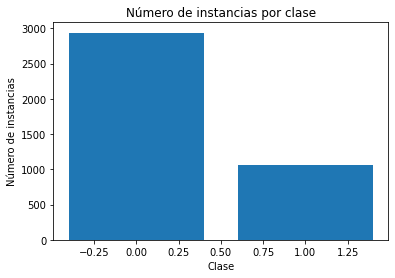

In [8]:
counts = gym_churn['churn'].value_counts()
print(counts)
print()
plt.title('Número de instancias por clase')
plt.xlabel('Clase')
plt.ylabel('Número de instancias')
plt.bar(counts.index, counts.values)
plt.show()

Como se puede apreciar, tenemos un desbalanceo grande a favor de la clase 0 (no cancela). Cuando entrenemos nuestros modelos tendremos que tener en cuenta este desbalanceo, tendremos que utilizar métricas de evaluación que tengan en cuenta este desbalanceo de clases, como por ejemplo: **precisión**, **recall** y **F1-score**.

Utilizaremos la distancia de Mahalanobis para poder validar los valores extremos, escogemos esta alternativa ya que toma en cuenta la suma de las diferencias en cada columna utilizando una matriz de covarianza para poder dar un valor total con el que luego podremos hacer una prueba de hipótesis nula de que los datos no son outliers:

Lo primero que realizaremos es calcular la matriz de covarianza del conjunto de datos, luego obtendremos el centroide del mismo. Con estos dos datos, podremos calcular la distancia de Mahalanobis para cada fila de datos y la añadiremos a nuestro dataframe en la columna 'mahalanobis_dist':

In [9]:
cov_matrix = np.cov(gym_churn.T)
centroid = np.mean(gym_churn, axis=0)

mahalanobis_dist = []
for i in range(len(gym_churn)):
    dist = mahalanobis(gym_churn.iloc[i], centroid, np.linalg.inv(cov_matrix))
    mahalanobis_dist.append(dist)

gym_churn['mahalanobis_dist'] = mahalanobis_dist

Ahora que tenemos la distancia en nuestra base de datos, podemos establecer en umbral para nuestra prueba de hipótesis. Utilizaremos un umbral típico de 0.05. Entonces, si nuestra distancia de Mahalanobis es mayor al umbral que obtuvimos quiere decir que tenemos valores atípicos significativos, imprimiremos los resultados:

In [10]:
threshold = chi2.ppf(0.95, df=len(gym_churn.columns)-1)
outliers = gym_churn[gym_churn['mahalanobis_dist'] > threshold]

print(f"Se identificaron {len(outliers)} valores atípicos utilizando la distancia de Mahalanobis.")

Se identificaron 0 valores atípicos utilizando la distancia de Mahalanobis.


Hemos confirmado que los valores extremos en nuestra base de datos no son realmente significativos para nuestro estudio. Finalmente, vamos a borrar la columna de distancia de mahalanobis para dejar limpia nuestra base:

In [11]:
gym_churn = gym_churn.drop('mahalanobis_dist', axis=1)
gym_churn.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


En conclusión, durante la exploración inicial de los datos, se descubrió que la base de datos incluye 14 columnas y 4000 filas. Todas las categorías son numéricas y no hay valores ausentes en el conjunto de datos. La mayoría de las columnas son booleanas y hay dos columnas con meses. Analizando los datos por columna, se notó que la mayoría de las columnas están bien distribuidas, con algunos sesgos hacia un lado (cero) en algunos casos. La frecuencia media de visitas por semana y el dinero gastado en otros servicios del gimnasio son los únicos valores que no se encuentran bien distribuidos. Vamos a hacer algunos gráficos para visualizar mejor toda la data.

### Visualización de la relación entre características y cancelaciones <a id='visualizacion_relacion'></a>

Lo primero que haremos es crear dos grupos, el primero para los que se fueron (cancelación) y el segundo para los que se quedaron. Luego sacaremos la media de las características para cada grupo:

In [12]:
gym_churn['partner'].mean()

0.48675

In [13]:
grouped_by_churn = gym_churn.groupby('churn')
grouped_by_churn.mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


De la tabla sobre los hábitos de los clientes en el gimnasio. Se ha encontrado que hay tantos hombres como mujeres y no se notan diferencia en esta categoría con respecto a la cancelación. La mayoría de los clientes viven cerca del gimnasio (85%) y tienden a cancelar un poco más los que viven más lejos. La gente que viene con su pareja tiende a cancelar menos que la gente que viene sola. La edad promedio de los clientes que se quedan es de 29.97 años, mientras que la de los que cancelan es de 26.98 años. Los clientes que se quedan gastan en promedio 158.44 dólares y van al gimnasio 2.02 veces a la semana. Por otro lado, los clientes que cancelan gastan en promedio 115.082 dólares y van al gimnasio 1.47 veces a la semana. El periodo de contrato promedio de los clientes que se quedan es de 5.747 meses, mientras que el de los que cancelan es de 1.72 meses. El tiempo en meses desde que el usuario llegó por primera vez al gimnasio es de 4.7 meses en promedio, pero para las cancelaciones es de 0.99 meses. La frecuencia de visitas al gimnasio en el último mes también ha variado, con una frecuencia de visitas a la semana de 2.027 para los clientes que se quedaron y de 1.044 para los que cancelaron.

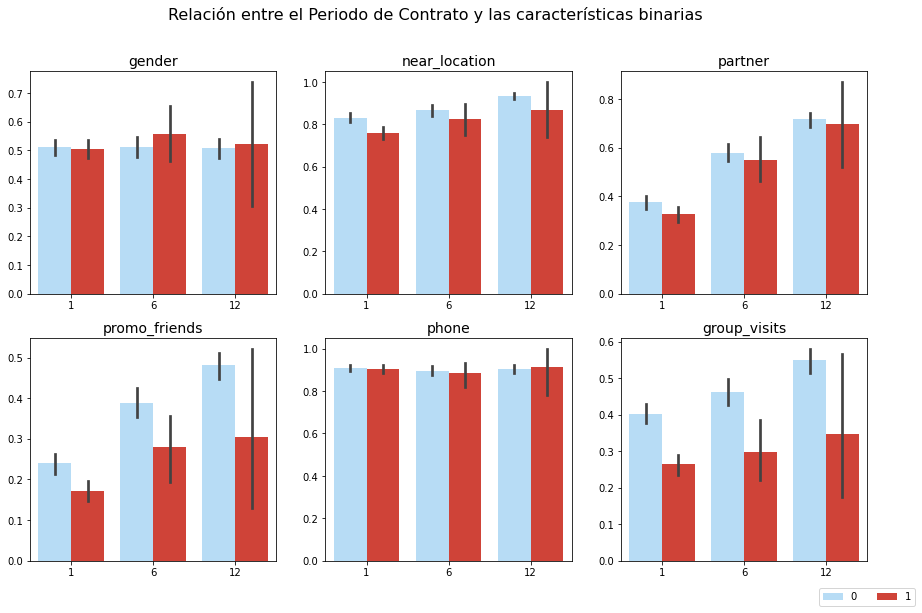

In [14]:
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
cols = '#addeff', '#e82d1f'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
for i, ax in enumerate(axs.flat):
    if i < len(columns):
        sns.barplot(x='contract_period', y=columns[i], data=gym_churn, hue='churn', palette=cols, ax=ax)
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')

plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1), ncol=2, frameon=True)

fig.suptitle('Relación entre el Periodo de Contrato y las características binarias', fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

Analizando los gráficos de relación entre el periodo de contrato y las características binarias de los clientes del gimnasio. Encontramos que los hombres tienden a cancelar más que las mujeres cuando contratan por seis o 12 meses. Por otro lado, los clientes que viven más lejos del gimnasio tienden a cancelar más, independientemente del número de meses contratados. Las parejas que contratan juntas y los clientes que fueron invitados por un amigo tienen una tendencia a cancelar menos. Los clientes que agregaron su número telefónico son la mayoría y presentan un escenario parejo independientemente del número de meses contratados. Finalmente, los clientes que participan en visitas grupales tienden a cancelar menos en todos los tipos de contratos.

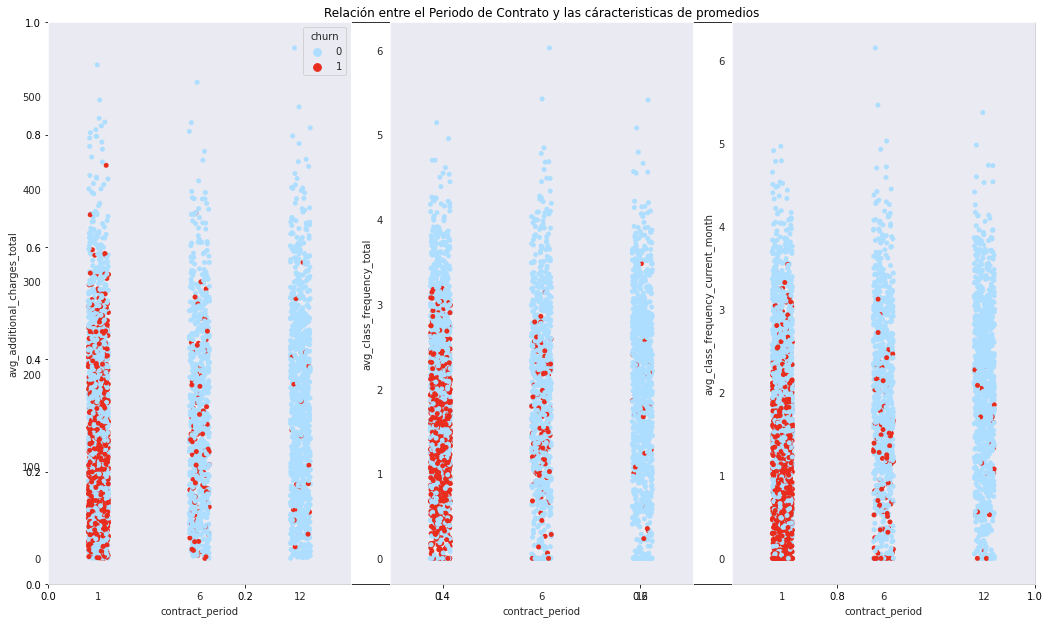

In [15]:
f = plt.figure(figsize=(15, 9))
gs = f.add_gridspec(1, 3)
plt.title('Relación entre el Periodo de Contrato y las cáracteristicas de promedios')

with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 0])
    sns.stripplot(x='contract_period', y='avg_additional_charges_total', hue='churn', data=gym_churn, palette=cols)

with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 1])
    sns.stripplot(x='contract_period', y='avg_class_frequency_total', hue='churn', data=gym_churn, palette=cols)
    plt.legend([], [], frameon=False)

with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 2])
    sns.stripplot(x='contract_period', y='avg_class_frequency_current_month', hue='churn', data=gym_churn, palette=cols)
    plt.legend([], [], frameon=False)
    
f.tight_layout()

A partir de estos gráficos, podemos concluir que los gastos adicionales y la frecuencia de visita son factores importantes que influyen en la decisión de cancelación de los clientes. Parece ser que los clientes que tienen gastos adicionales más bajos y que van al gimnasio menos frecuentemente son más propensos a cancelar. Sin embargo, para los clientes que contratan por un período de 6 o 12 meses, los gastos adicionales parecen ser un factor menos relevante en la decisión de cancelación. Además, los clientes que van al gimnasio más frecuentemente son menos propensos a cancelar, independientemente del período de contrato.

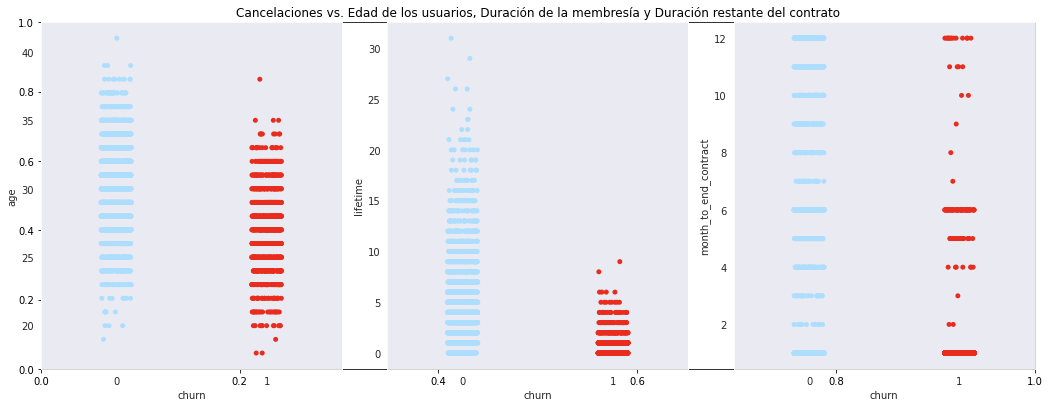

In [16]:
f = plt.figure(figsize=(15, 6))
gs = f.add_gridspec(1, 3)
plt.title('Cancelaciones vs. Edad de los usuarios, Duración de la membresía y Duración restante del contrato')

with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 0])
    sns.stripplot(x='churn', y='age', data=gym_churn, palette=cols)

with sns.axes_style("dark"):    
    ax = f.add_subplot(gs[0, 1])
    sns.stripplot(x='churn', y='lifetime', data=gym_churn, palette=cols)

with sns.axes_style("dark"):
    ax = f.add_subplot(gs[0, 2])
    sns.stripplot(x='churn', y='month_to_end_contract', data=gym_churn, palette=cols)
    
f.tight_layout()

A partir de los tres gráficos, podemos concluir que la edad, la duración de la membresía y el tiempo restante en el contrato son factores importantes en las cancelaciones de los clientes de un gimnasio. Se ha identificado que los clientes jóvenes entre 25 y 30 años son más propensos a cancelar su membresía, mientras que la mayoría de las cancelaciones ocurren en los primeros meses de la membresía. Además, se ha observado que los contratos que tienen más cancelaciones son los de 6 meses y que la mayoría de las cancelaciones ocurren en el mes de vencimiento del contrato. Estos hallazgos pueden ser útiles para las estrategias de retención de clientes y para mejorar la satisfacción del cliente en un gimnasio.

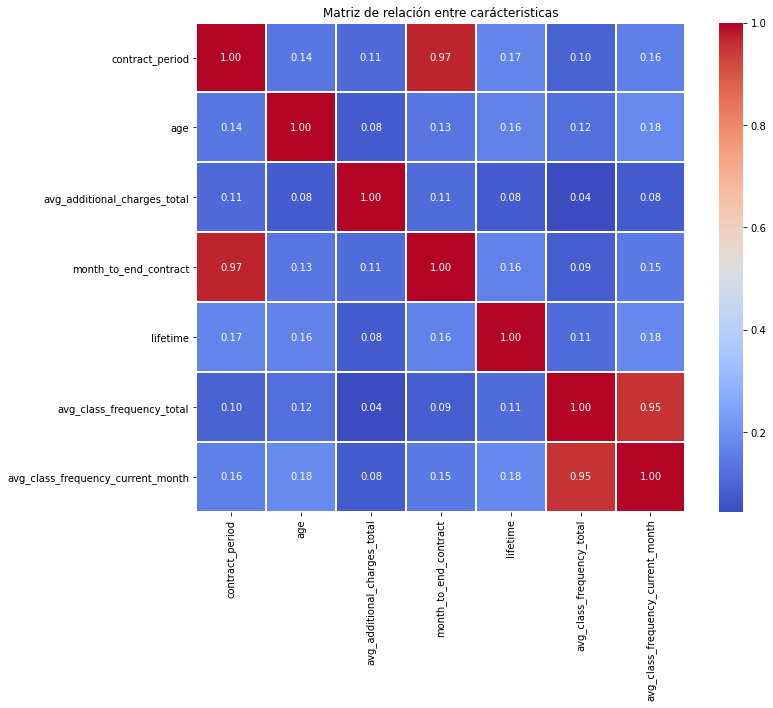

In [17]:
quant_cols = ['contract_period', 'age', 'avg_additional_charges_total',
              'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
              'avg_class_frequency_current_month']

gym_churn_quant = gym_churn[quant_cols]

cm = gym_churn_quant.corr()

plt.figure(figsize = (12,9))
plt.title('Matriz de relación entre carácteristicas')
sns.heatmap(cm, fmt= '.2f', annot = True, square = True, linewidths=1, linecolor='white', cmap="coolwarm")
plt.show(block=False)

Notamos que el momento en que termina el contrato y la duración del contrato en sí mismo están estrechamente relacionados (0.97), lo que indica que las personas deciden cancelar o renovar su membresía en base al tiempo restante en su contrato. Por otro lado, la edad y la duración de la membresía tienen una correlación más baja con las cancelaciones, lo que sugiere que no son factores tan relevantes en la decisión de los usuarios de cancelar o renovar su membresía. La frecuencia de visitas al gimnasio también parece tener una correlación alta con las cancelaciones, lo que indica que la actividad en el gimnasio es un factor importante en la decisión de los usuarios de mantener o cancelar su membresía. Finalmente vamos a crear tablas de contingencia para estudiar la relación entre la variable objetivo y las variables cualitativas:

In [18]:
cat_cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']

cont_tables = []
for col in cat_cols:
    cont_table = pd.crosstab(index=gym_churn[col], columns=gym_churn['churn'], normalize='index')
    cont_tables.append(cont_table)

Para facilitar la visualización crearemos una visualización:

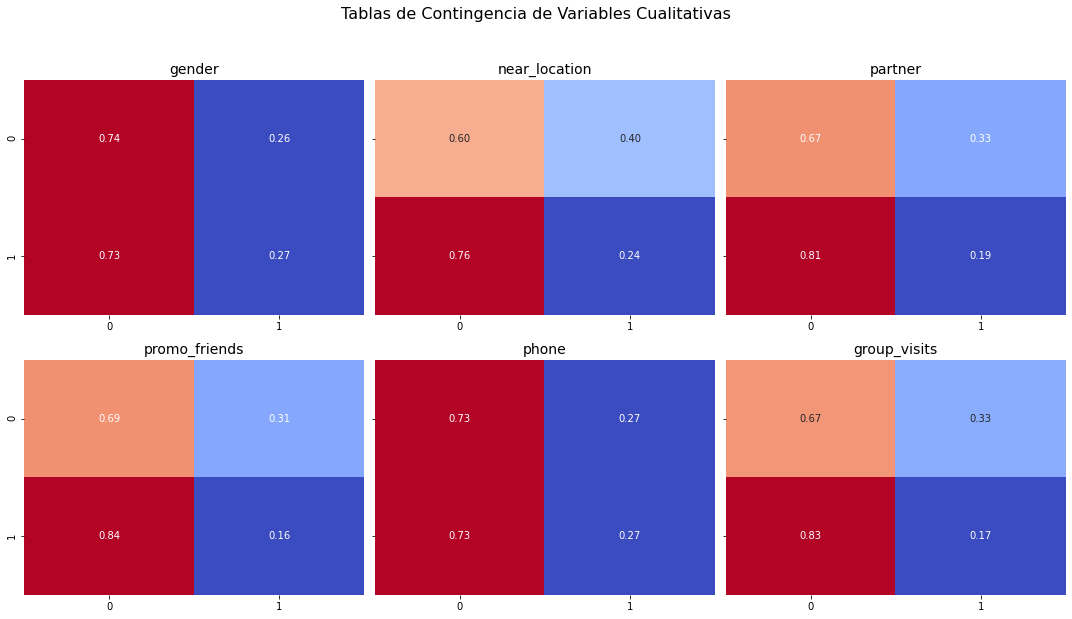

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 9), sharey=True)
fig.suptitle('Tablas de Contingencia de Variables Cualitativas', fontsize=16)

for i, ax in enumerate(axs.flat):
    if i < len(cont_tables):
        sns.heatmap(cont_tables[i], annot=True, fmt=".2f", cmap="coolwarm", cbar=False, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{columns[i]}', fontsize=14)
    else:
        ax.axis('off')      
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

De nuestro gráfico podemos hacer las siguientes observaciones:
- La variable "gender" no parece estar relacionada de manera significativa con la probabilidad de cancelación. La proporción de clientes que abandonan es casi idéntica para hombres y mujeres.

- La variable "near_location" muestra una diferencia significativa. Los clientes que viven cerca del gimnasio tienen una probabilidad mucho menor de cancelar que los que viven lejos.

- La variable "partner" también muestra una diferencia significativa. Los clientes que tienen una pareja que también es miembro del gimnasio tienen una probabilidad mucho menor de abandonar que los que no tienen pareja.

- La variable "promo_friends" también muestra una diferencia significativa. Los clientes que se unieron al gimnasio a través de una promoción de amigos tienen una probabilidad mucho menor de abandonar que los que no se unieron a través de esta promoción.

- La variable "phone" no parece estar relacionada de manera significativa con la probabilidad de abandono. La proporción de clientes que abandonan es casi idéntica para aquellos que proporcionaron su número de teléfono y aquellos que no lo hicieron.

- La variable "group_visits" muestra una diferencia significativa. Los clientes que asisten a clases en grupo tienen una probabilidad mucho menor de abandonar que los que no asisten.

Finalmente, vamos a realizar una prueba de hipótesis para identificar si existe una relación o no entre las variables. Utilizaremos un nivel de significancia de 0.05 como para la prueba anterior:

In [24]:
alpha = 0.05

for col in cat_cols:
    contingency_table = pd.crosstab(gym_churn[col], gym_churn['churn'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Variable categórica: {col}")
    print(f"p-valor: {p}")
    if p < alpha:
        print("Hay evidencia para rechazar la hipótesis nula: las variables están relacionadas")
        print()
    else:
        print("No hay suficiente evidencia para rechazar la hipótesis nula: las variables no están relacionadas")
        print()

Variable categórica: gender
p-valor: 0.9928687015043638
No hay suficiente evidencia para rechazar la hipótesis nula: las variables no están relacionadas

Variable categórica: near_location
p-valor: 8.137638074792214e-16
Hay evidencia para rechazar la hipótesis nula: las variables están relacionadas

Variable categórica: partner
p-valor: 2.372635812097966e-23
Hay evidencia para rechazar la hipótesis nula: las variables están relacionadas

Variable categórica: promo_friends
p-valor: 1.584561975964236e-24
Hay evidencia para rechazar la hipótesis nula: las variables están relacionadas

Variable categórica: phone
p-valor: 0.989015836722021
No hay suficiente evidencia para rechazar la hipótesis nula: las variables no están relacionadas

Variable categórica: group_visits
p-valor: 2.1408744660884118e-28
Hay evidencia para rechazar la hipótesis nula: las variables están relacionadas

Variable categórica: churn
p-valor: 0.0
Hay evidencia para rechazar la hipótesis nula: las variables están relac

Con esto comprobamos nuestras observaciones anteriores.

### Conclusión I - Descarga y Ánalisis de Datos <a id='conclusion_1'></a>

La base de datos consta de 4000 filas y 14 columnas. Todos los valores son numéricos y no hay valores ausentes en los datos. Se renombraron las columnas para tener todos los nombres en minúsculas. Después de analizar los datos usando el método describe(), pudimos concluir que la mayoría de las columnas son de datos booleanos (ceros o unos). También hay dos columnas con meses (contract_period y month_to_end_contract) y el resto son números, ya sea enteros como age y lifetime o flotantes como avg_additional_charges_total, avg_class_frequency_total y avg_class_frequency_current_month. 

Al analizar los datos por columna, observamos que la mayoría de las columnas tienen datos simétricos y bien distribuidos, pero algunas columnas, como contract_period, month_to_end_contract, avg_additional_charges y avg_class_frequency_total, tienen valores más dispares. La tasa de cancelación promedio es de 0.26 y la desviación estándar es de 0.44, lo que indica que la columna tiene más ceros que unos.

Gracias a los distintos gráficos observamos que los factores relacionados con la ubicación, el género, la pareja, la edad, los gastos, la frecuencia de visitas, la duración de la membresía, el tiempo restante en el contrato y las visitas grupales influyen en la decisión de cancelación de los clientes de un gimnasio.

Se encontró que los clientes jóvenes y que viven lejos del gimnasio son más propensos a cancelar su membresía. Los clientes que vienen con su pareja y los que participan en visitas grupales tienden a cancelar menos. Los gastos adicionales y la frecuencia de visita también son factores importantes en la decisión de cancelación. Los clientes que tienen gastos adicionales más bajos y que van al gimnasio menos frecuentemente son más propensos a cancelar.

## Modelos de Predicción de Cancelación de Usuarios <a id='prediccion'></a>

Crearemos un modelo de clasificación binaria para clientes donde la característica objetivo es la marcha del usuario del mes siguiente. Para ello primero dividiremos los datos:

In [27]:
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

Ahora dividiremos los datos en conjuntos de entrenamiento y prueba:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Crearemos una función para generar nuestras métricas:

In [29]:
def print_all_metrics(y_true, y_pred, y_proba, title = 'Métricas de clasificación'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

### Modelo de regresión logística <a id='regresion_logistica'></a>

Para evitar errores al momento de entrenar nuestro modelo escalaremos los datos primero:

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

A continuación definiremos el modelo y lo entrenaremos:

In [31]:
model_lr = LogisticRegression(random_state=0)

model_lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

Entonces podemos realizar predicciones:

In [32]:
predictions_lr = model_lr.predict(X_test)
probabilities_lr = model_lr.predict_proba(X_test)[:,1]

print_all_metrics(y_test, predictions_lr, probabilities_lr, title='Métricas para el Modelo de Regresión logística:')

Métricas para el Modelo de Regresión logística:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [33]:
predictions_lr_train = model_lr.predict(X_train)
probabilities_lr_train = model_lr.predict_proba(X_train)[:,1]

print_all_metrics(y_train, predictions_lr_train, probabilities_lr_train, title='Métricas para el Modelo de Regresión logística (entrenamiento):')

Métricas para el Modelo de Regresión logística (entrenamiento):
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.85
	F1: 0.87
	ROC_AUC: 0.98


En general, parece que el modelo de regresión logística está funcionando bastante bien en ambos conjuntos de datos. Las métricas son consistentes lo que el modelo está separando bien los datos.

### Modelo de bosque aleatorio <a id='bosque_aleatorio'></a>

A continuación definiremos el modelo y lo entrenaremos:

In [34]:
model_rfc = RandomForestClassifier(n_estimators = 100, random_state=0)

model_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Entonces podemos realizar predicciones:

In [35]:
predictions_rfc = model_rfc.predict(X_test)
probabilities_rfc = model_rfc.predict_proba(X_test)[:,1]

print_all_metrics(y_test, predictions_rfc, probabilities_rfc, title='Métricas para el Modelo de Bosque Aleatorio:')

Métricas para el Modelo de Bosque Aleatorio:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


In [36]:
predictions_rfc_train = model_rfc.predict(X_train)
probabilities_rfc_train = model_rfc.predict_proba(X_train)[:,1]

print_all_metrics(y_train, predictions_rfc_train, probabilities_rfc_train, title='Métricas para el Modelo de Bosque Aleatorio (Entrenamiento):')

Métricas para el Modelo de Bosque Aleatorio (Entrenamiento):
	Accuracy: 1.00
	Precision: 1.00
	Recall: 1.00
	F1: 1.00
	ROC_AUC: 1.00


Los resultados de las métricas para el modelo de Bosque Aleatorio parecen indicar que el modelo está sobreajustando los datos de entrenamiento. Todas las métricas parecen perfectas lo que no es realista. Veremos si optimizando algunos hiperparámetros podemos mejorar el rendimiento de este modelo:

In [41]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid.best_params_}")
print(f"Puntaje de validación cruzada: {grid.best_score_}")

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Puntaje de validación cruzada: 0.9165625000000001


Obtuvimos un puntaje de validación cruzada alto, lo que indica que con estos parámetros podríamos mejorar considerablemente nuestro modelo. Veamos que obtenemos entonces:

In [45]:
model_rfc_2 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=2, max_features='sqrt')

model_rfc_2.fit(X_train, y_train)

predictions_rfc_2 = model_rfc_2.predict(X_test)
probabilities_rfc_2 = model_rfc_2.predict_proba(X_test)[:,1]

print_all_metrics(y_test, predictions_rfc_2, probabilities_rfc_2, title='Métricas para el Modelo de Bosque Aleatorio:')

predictions_rfc_train_2 = model_rfc_2.predict(X_train)
probabilities_rfc_train_2 = model_rfc_2.predict_proba(X_train)[:,1]

print_all_metrics(y_train, predictions_rfc_train_2, probabilities_rfc_train_2, title='Métricas para el Modelo de Bosque Aleatorio (Entrenamiento):')

Métricas para el Modelo de Bosque Aleatorio:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.78
	F1: 0.80
	ROC_AUC: 0.97
Métricas para el Modelo de Bosque Aleatorio (Entrenamiento):
	Accuracy: 0.96
	Precision: 0.94
	Recall: 0.91
	F1: 0.92
	ROC_AUC: 0.99


Si bien nuestras métricas en el modelo con hiperparámetros bajan un poco en comparación con el modelo original, en el entrenamiento obtuvimos mejores métricas lo que indica que podriamos haber mejorado el sobreajuste original.

### Conclusión II - Modelos de Predicción de Cancelación de Usuarios <a id='conclusion_2'></a>

Compararemos el modelo de regresión lógistica con el modelo de bosque aleatorio con los nuevos hiperparámetros. Los dos modelos tienen una **Accuracy** y un **ROC_AUC** bastante altos, lo que indica que ambos son bastante precisos en la clasificación de los datos. Sin embargo, el modelo de regresión logística tiene una **Precision** y un **Recall** ligeramente superiores, lo que significa que tiene una mejor capacidad para detectar verdaderos positivos y minimizar los falsos positivos.

La métrica **F1** que es una medida de equilibrio entre **Precision** y **Recall**, es buena para evaluar la calidad del modelo. En este caso, el modelo de regresión logística también es el que tiene una **F1** ligeramente superior. O sea, que es un modelo más preciso el bosque aleatorio para este estudio.

En conclusión, a partir de las métricas obtenidas, podemos decir que el modelo de regresión logística es el que funciona mejor en este caso.

## Clústeres de Usuarios <a id='cluster'></a>

Utilizaremos todas las categorías (dejando de lado la columna 'churn'), lo primero que haremos con ellas es estandarizar los datos:

In [42]:
gym_churn_cat = gym_churn.drop('churn', axis=1)

sc = StandardScaler()
x_sc = sc.fit_transform(gym_churn_cat)

Crearemos una matriz de distancia basada en la matriz de características estandarizada y trazaremos un dendrograma:

In [43]:
distance_matrix = pdist(x_sc)
linkage_matrix = linkage(distance_matrix, method='ward')

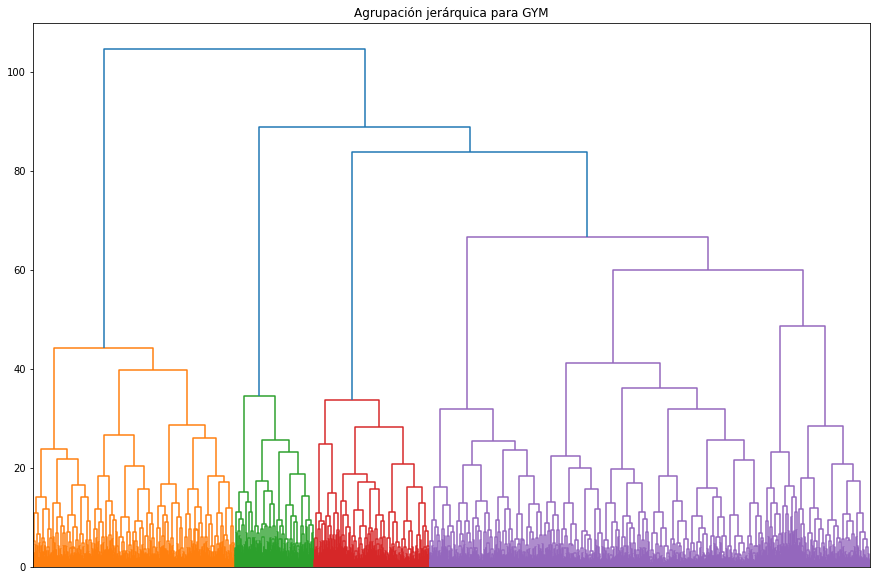

In [44]:
plt.figure(figsize=(15, 10))  
dendrogram(linkage_matrix, orientation='top', no_labels=True)
plt.title('Agrupación jerárquica para GYM')
plt.show()

Encontramos que el número óptimo de clústeres sugerido es de 4 (que corresponden a los cuatro colores gráficados). Con estos datos, podemos entrenar el modelo de clustering con el algortimo K-means y predicir los clústeres de clientes. Sin embargo, para estar seguros de que esta es la mejor partición. Vamos a comparar la partición de 4 clústers con una de 5 utilizando el índice Davies-Bouldin:

In [46]:
km4 = KMeans(n_clusters = 4, random_state=0)
km4.fit(x_sc)

KMeans(n_clusters=4, random_state=0)

In [47]:
db_score_4 = davies_bouldin_score(x_sc, km4.labels_)
print(f"El índice de Davis-Bouldin para una partición de 4 clústers es de: {db_score_4:.2f}")

El índice de Davis-Bouldin para una partición de 4 clústers es de: 2.08


In [48]:
km5 = KMeans(n_clusters = 5, random_state=0)
labels = km5.fit_predict(x_sc)

In [49]:
db_score_5 = davies_bouldin_score(x_sc, km5.labels_)
print(f"El índice de Davis-Bouldin para una partición de 5 clústers es de: {db_score_5:.2f}")

El índice de Davis-Bouldin para una partición de 5 clústers es de: 1.94


Mientras menor sea el valor del índice Davis-Bouldin, mejor será la calidad de la partición. En conclusión, para este caso en particular es mejor utilizar la base de datos partida en 5 clústers. Añandiremos nuestros labels a la base de datos:

In [50]:
gym_churn['cluster_km'] = labels

Ahora podemos sacar las estadísticas de valores medios por clúster y representar los resultados en gráficos. Lo primero será crear una función para representar gráficos de caractéristicas emparejadas:

In [51]:
gym_churn.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Vamos a analizar los datos por clúster:
* Clúster 0: Este es el grupo con la tasa de abandono más baja (0.02), asisten 2 veces a la semana al gimnasio, son de los que tienen los gastos adicionales más altos y tienen los contratos promedio más largos (11 meses) y tiene tiempo promedio de membresía es de 4.73 (de los más altos).
* Clúster 1: Tiene una taza de abandono moderada baja de 0.267. En promedio asisten al gimnasio 1.84 veces a la semana. El promedio de meses de contratación es de 4.78 meses, en este clúster no entregaron su número telefónico. En su mayoría no llegaron por la promoción de amigos.
* Clúster 2: Este clúster se caracteriza por todos sus usuarios viven lejos del gimnasio, no tienen pareja, no vinieron por promos de amigos y su contrato promedio es de 2.35 meses. El promedio de edad es de 28.47 años, tienen un gasto adicional más bien bajo. Asisten 1.66 veces a la semana al gimnasio y su tasa de cancelación es bastante alta (0.44).
* Clúster 3: Este clúster tiene la tasa de deserción más alta (0.51), en promedio asisten 1.24 veces a la semana, son los que menos gastan en adicionales, tienen la edad promedio más baja (28.16), el contrato promedio es por 1.94 meses, finalmente no vienen invitados ni con pareja, pero todos viven cerca del gym.
* Clúster 4: Este clúster tiene una tasa de abandono muy baja (0.06), Este grupo es el que más veces a la semana asiste al gimnasio (2.85), son los que más gastan en adicionales, su promedio de edad es el más alto (30.12), el periodo de contrato promedio es de 2.66 meses.

Vamos a hacer unos diagramas de cajas para mostrar la distribución de los datos en cada clúster. Nos enfocaremos en las columnas de edad, la duración del contrato y la cantidad de tiempo que lleva viniendo el cliente al gimnasio. Lo que nos interesa revisar en estas columnas es si tenemos muchos valores atípicos en los clústers:

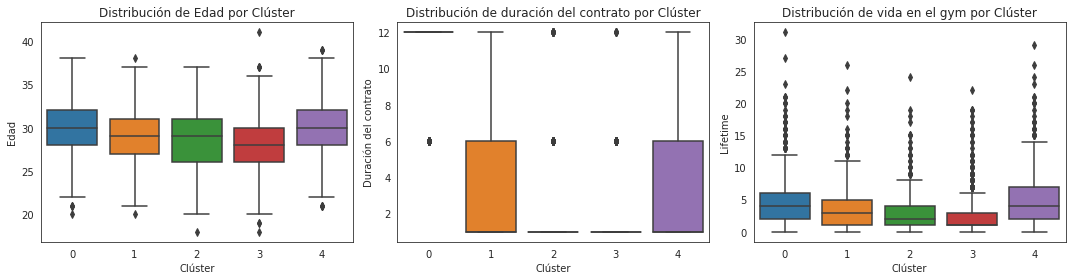

In [52]:
f = plt.figure(figsize=(15, 4))
gs = f.add_gridspec(1, 3)

with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(x='cluster_km', y='age', data=gym_churn)
    plt.title('Distribución de Edad por Clúster')
    plt.xlabel('Clúster')
    plt.ylabel('Edad')

with sns.axes_style("white"):    
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(x='cluster_km', y='contract_period', data=gym_churn)
    plt.title('Distribución de duración del contrato por Clúster')
    plt.xlabel('Clúster')
    plt.ylabel('Duración del contrato')

with sns.axes_style("white"):
    ax = f.add_subplot(gs[0, 2])
    sns.boxplot(x='cluster_km', y='lifetime', data=gym_churn)
    plt.title('Distribución de vida en el gym por Clúster')
    plt.xlabel('Clúster')
    plt.ylabel('Lifetime')
    
f.tight_layout()

Como podemos apreciar, la distribución de los datos con respecto a la edad está bastante bien distribuida. Notamos que en el clúster 3 tenemos algunos valores excepcionales tanto por lo alto como por lo bajo. En cambio, mirando el gráfico de cajas de la duración del contrato por clúster, podemos notar que para los clústers 2, 3 los datos excepcionales están muy por encima de los promedios. Esto indica que estos grupos tienen valores atipicos que están afectando la media. En el caso del clúster 0, es justo al inverso, la media está arriba del todo, lo que indica que los valores extremos pequeños están afectando la distribución. Finalmente, para el tiempo que dura la membresía (la vida del usuario en el gym) podemos ver que hay varios valores átipicos para todos los clústers (lo que parece ser una constante). 

Haremos unos histogramas para revisar la forma en que se distribuyen los datos en las columnas frecuencia promedio de asistencia al gymnasio, los cargos adicionales, las promociones de amigos y parejas.

In [57]:
def histograma_clusters(df, n_clusters, column):
    fig, axs = plt.subplots(1, n_clusters, figsize=(15, 6), sharey="all")
    for i in range(n_clusters):
        axs[i].hist(df[df['cluster_km'] == i][column])
        axs[i].set_title('Clúster {}'.format(i))
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

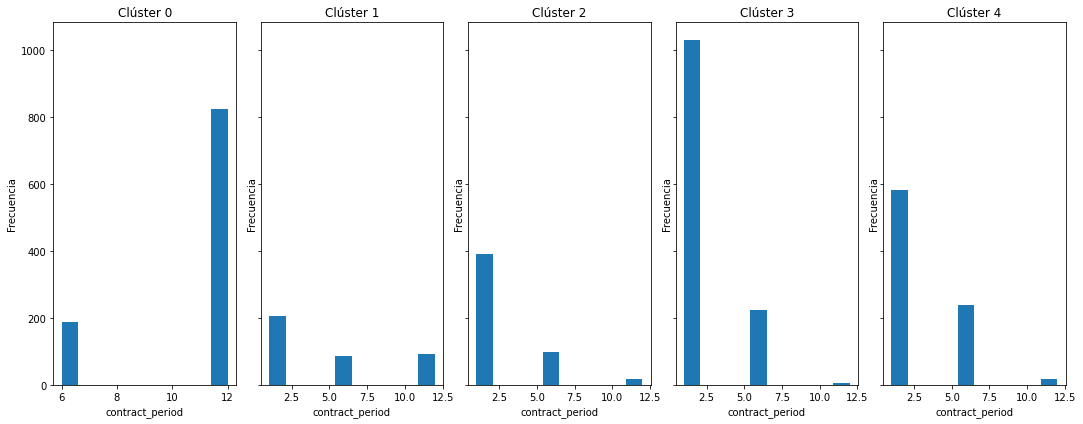

In [58]:
histograma_clusters(gym_churn, 5, 'contract_period')

Sacamos el histograma del periodo de contrato porque las diferencias eran demasiado grande en el boxplot. Entonces notamos que en el clúster 0, la mayoría de los usuarios contrataron 12 meses y unos pocos 6 meses. EN el clúster 1, notamos una mayoría de contratos menores a 2.5 meses (200 contratos) y luego se dividen entre 6 meses (90 contratos) y 12 meses (100 contratos). En el clúster 2 casi todos los contratos son menores a 2.5 meses, el resto son excepcionales. Lo mismo pasa en el clúster 3. El clúster 4 tiene la mayoría de los contratos bajo los 2.5 meses (580 contratos) y 230 contratos de 6 meses, los contratos de 12 meses casí no existen. También podemos notar que los clúster 0 y clúster 3 tienen muchos más datos que los otros.

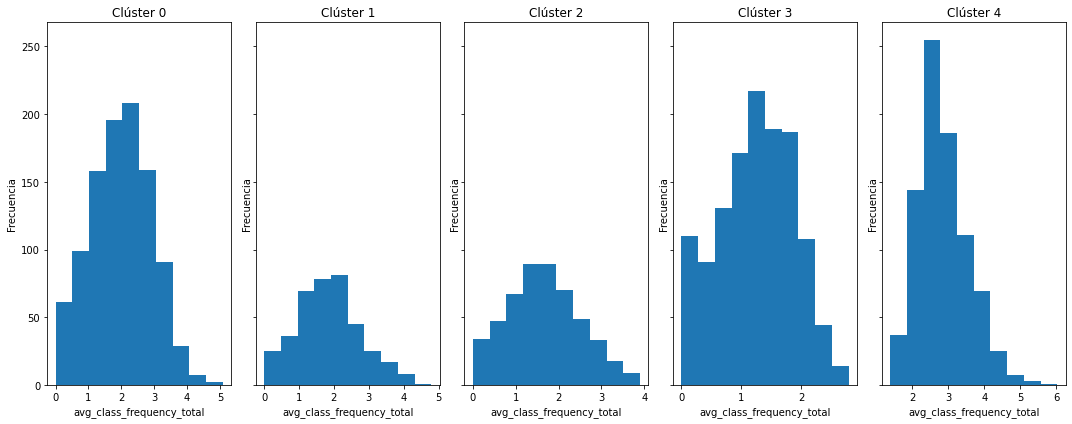

In [59]:
histograma_clusters(gym_churn, 5, 'avg_class_frequency_total')

Viendo los histogramas de la frecuencia de visitas semanales promedio por clúster podemos notar que los clústeres 1 y 2 tienen la distribución más normal. Además, los clústeres 1, 2 y 4 parecen estar más inclinados hacia la izquierda. El único clúster que tiene una cola más bien larga es el número 4 lo que indica que podría haber algunos valores atípicos. En los clústeres 0, 1 y 2 la mayoría de los datos tienden a concentrase en los 2 días semanales. El clúster 3 tiende a bajar un poco de ese promedio y el clúster 4 está casi en los 3 días semanales. Se puede apreciar una mayor frecuencia en los datos en los clúster 0, 3 y 4, mientras que los clúster 1 y 2 parecen mejor distribuidos.

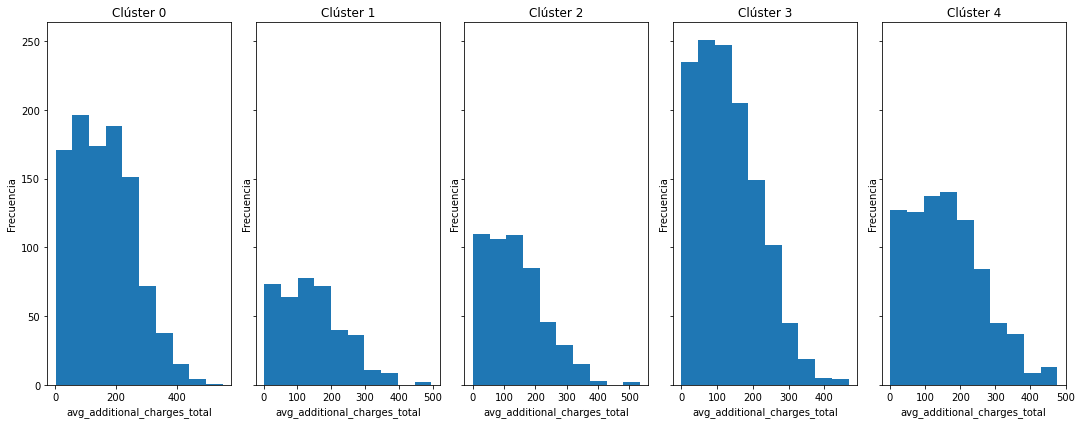

In [60]:
histograma_clusters(gym_churn, 5, 'avg_additional_charges_total')

En los histógramas de los cargos adicionales notamos que todos están inclinados a la izquierda. Los clúster 1 y 4 tienden a estar mejor distribuidos, mientras que los clúster 0 y 3 tienden a tener una mayor aglomeración de datos.

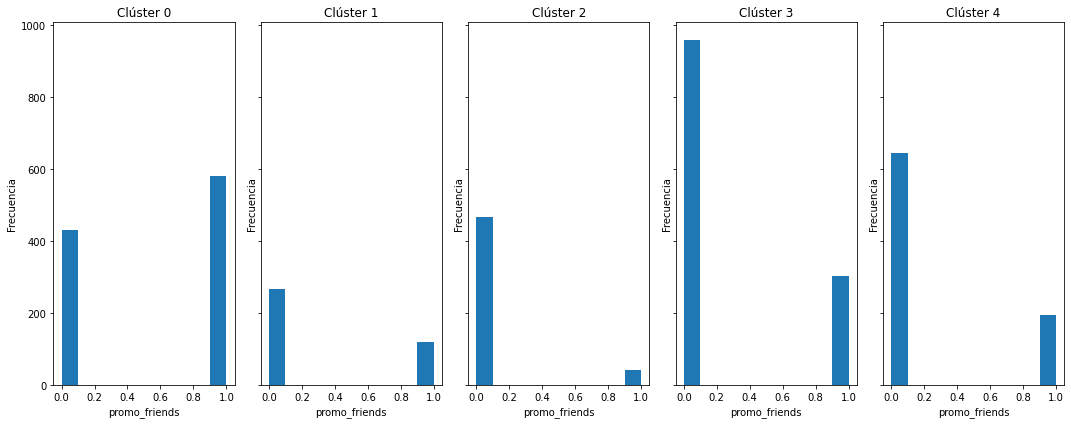

In [61]:
histograma_clusters(gym_churn, 5, 'promo_friends')

En los histogramas sobre la promoción con amigos, nos encontramos con que los clústeres 1, 2, 3 y 4 corresponden a grupos en los que mayoritariamente contrataron sin promos. Solo el clúster 0, tiene una mayoría de usuarios que contrataron por invitaciones de amigos. La distribución tiende a no ser tan dispar en la mayoría de los clúster pero en los clúster 3 y 4 las diferencias son significativas.

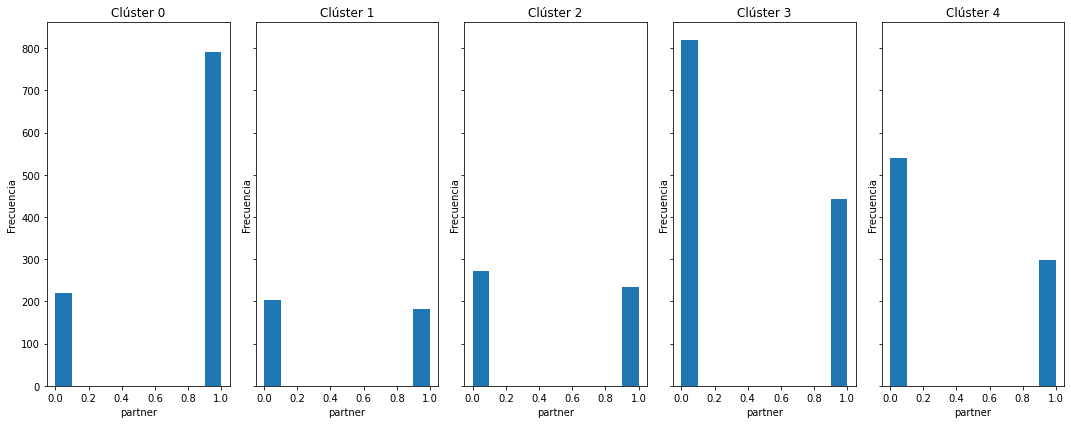

In [63]:
histograma_clusters(gym_churn, 5, 'partner')

Con respecto a ir al gimnasio con la pareja, tenemos una distribución más homogénea en los clústeres 1 y 2, dónde se nota solo una leve ventaja de los clientes sin pareja. El clúster 0 tiene mayoritariamente clientes con pareja. Finalmente, los clústeres 3 y 4 tienen mayoritariamente clientes sin pareja (aproximadamente 2/3).

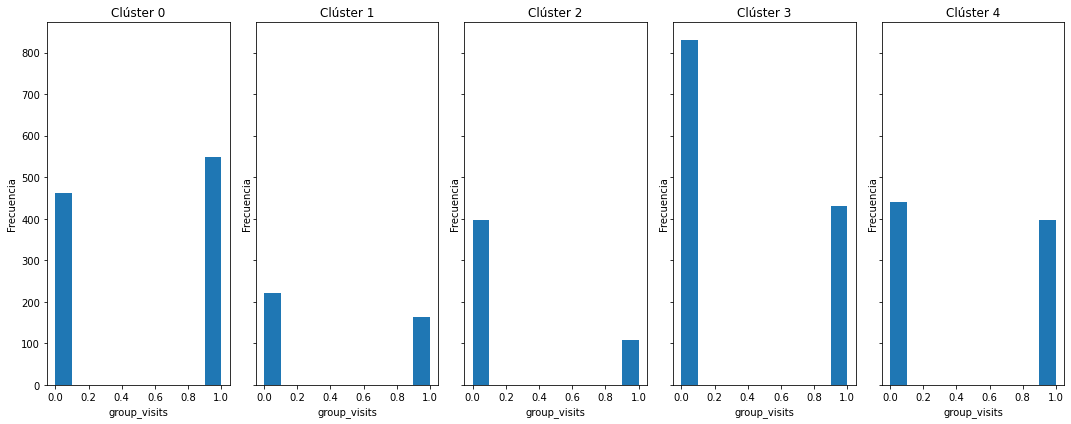

In [64]:
histograma_clusters(gym_churn, 5, 'group_visits')

En los clústeres 0 y 4 notamos la distribución bastante pareja, se comportan como espejo en el primero gana por un poco las sesiones grupales, en el último al revés ganan por poco los clientes que no participan en estas sesiones. En el clúster 1 la frecuencia en los datos es mucho menor.En el clúster 3, esta diferencia se incrementa hasta llegar al máximo. En el clúster 2, casi todos no participan. 

Finalmente, revisaremos la columna de cancelación con los dos tipos de gráficos:

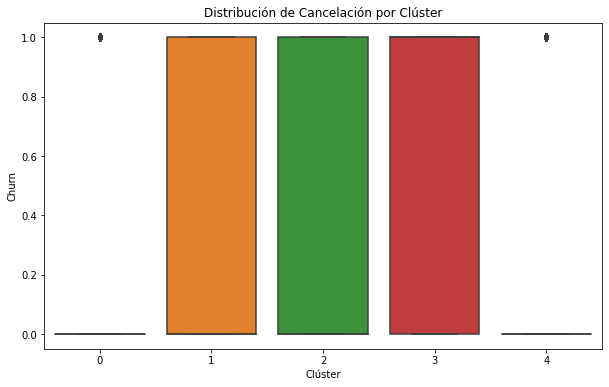

In [65]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_km', y='churn', data=gym_churn)
plt.title('Distribución de Cancelación por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Churn')
plt.show()

Como se aprecia en las cajas, los clústeres 1, 2 y 3 son parejos, pero tanto el clúster 0 como el 4 tienen sus valores concentrados abajo (0), o sea casi sin cancelaciones. 

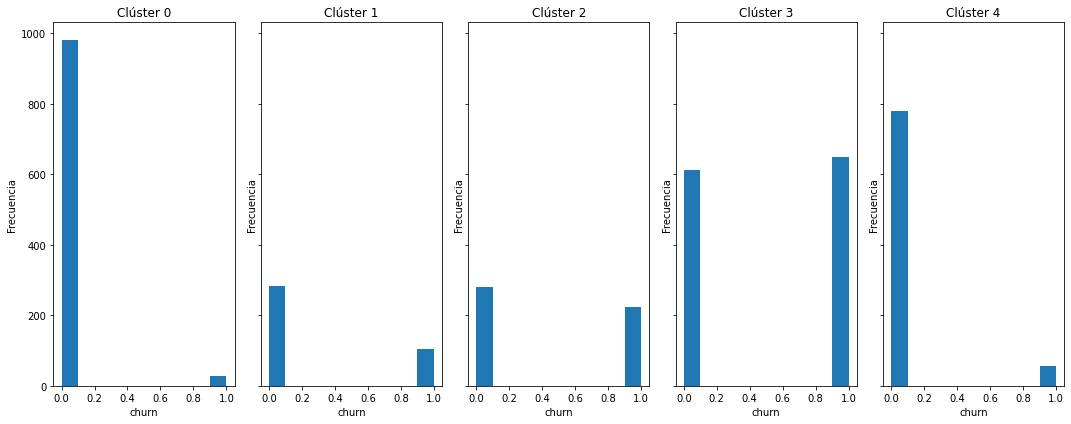

In [66]:
histograma_clusters(gym_churn, 5, 'churn')

El histograma efectivamente refuerza lo que vimos en los boxplot de los clústeres 0 y 4, casi no encontramos cancelaciones en esos clústeres. El clúster uno es el que tiene un tercio de abandonos, el clúster 2 tiene casi los que se quedan y los que cancelan igualados y el clúster 3 tiene un poco más de abandonos que de clientes que se queden. Finalmente, calcularemos la tasa de cancelación para cada clúster:

In [58]:
churn_rates = gym_churn.groupby('cluster_km')['churn'].mean()
print(churn_rates)

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64


### Conclusión III - Clústeres de Usuarios <a id='conclusion_3'></a>

En base a los datos analizados, se encontró que una partición en 5 clústeres es mejor que una partición en 4 clústeres, según el índice Davies-Bouldin. Los resultados del análisis de los clústeres obtenidos revelan diferencias significativas en los comportamientos y características de los usuarios del gimnasio. Se pueden identificar similitudes y diferencias entre los diferentes clústeres. Por ejemplo, los usuarios del Clúster 0 tienen la tasa de abandono más baja y tienen los contratos promedio más largos, mientras que los del Clúster 3 tienen la tasa de abandono más alta y el periodo de contrato promedio más corto. El Clúster 4 se caracteriza por tener una tasa de abandono muy baja y por asistir al gimnasio con mayor frecuencia. Por otro lado, el Clúster 2 se compone de usuarios que viven lejos del gimnasio, tienen gastos adicionales más bajo (los segundos más bajos) y asisten al gimnasio con menos frecuencia que el resto (también el segundo más bajo).

## Conclusiones y Recomendaciones <a id='conclusion_4'></a>

En conclusión, este proyecto de análisis de datos del gimnasio proporcionó información valiosa sobre los factores que influyen en la decisión de cancelación de la membresía. Además, se utilizó la regresión logística y el bosque aleatorio para construir modelos predictivos precisos para la tasa de cancelación, siendo el de regresión lógistica el que recomendamos utilizar debido a las validaciones obtenidas. 

Finalmente, mediante el análisis de clústeres, se identificaron cinco grupos de clientes con diferentes comportamientos y características. Estos resultados pueden ser útiles para el gimnasio para desarrollar estrategias de retención de clientes y mejorar la satisfacción del cliente.

En base a los datos obtenidos, aLgunas sugerencias podrían ser las siguientes:
- Ofrecer promociones y descuentos a los clientes que asisten varias veces al gimnasio, que tengan sobre 30 años y que tienen contratos más bien cortos promedio de 3 meses, para fomentar la fidelidad a largo plazo.
- Ofrecer programas de entrenamiento en grupo y fomentar la asistencia de los clientes con sus parejas y amigos para aumentar la interacción social y el compromiso con el gimnasio.
- Ofrecer promociones para las clases grupales o descuentos en cafetería a los que viven más lejos para promocionar la interacción con otros clientes. 